In [2]:
import json
import pandas as pd
import numpy as np
import sklearn
from zipfile import ZipFile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
data_folder = Path('data')

In [4]:
train_zip = 'train.json.zip'
test_zip = 'test.json.zip'

In [5]:
def read_json_zip(zip_file_path):
    with ZipFile(zip_file_path, "r") as z:
        with z.open(zip_file_path.stem) as f:
            data = json.loads(f.read())
    return data

In [6]:
data_train = read_json_zip(data_folder.joinpath(train_zip))
data_test = read_json_zip(data_folder.joinpath(test_zip))


In [7]:
print('Number of training examples: %s\n Number of testing examples: %s' %(len(data_train), len(data_test)))

Number of training examples: 39774
 Number of testing examples: 9944


In [8]:
print('Keys in training json: %s\nKeys in test data json: %s' %(data_train[0].keys(), data_test[0].keys()))

Keys in training json: dict_keys(['id', 'cuisine', 'ingredients'])
Keys in test data json: dict_keys(['id', 'ingredients'])


Lets convert the data to pandas format for easy usage

In [15]:
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

In [16]:
df_train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [17]:
df_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


Lets check the class (cuisine) distribution in the trainin data

In [24]:
cuisine_count = df_train['cuisine'].value_counts()
# print(cuisine_count)

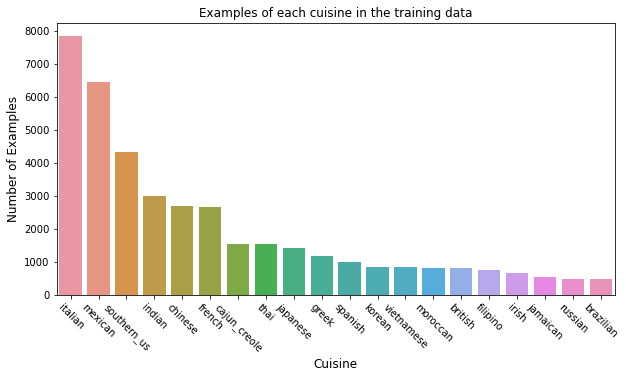

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(cuisine_count.index, cuisine_count.values, alpha=1)
plt.title('Examples of each cuisine in the training data')
plt.ylabel('Number of Examples', fontsize=12)
plt.xlabel('Cuisine', fontsize=12)
plt.xticks(rotation=-45)
plt.show()

## Ingredient count per Cuisine

In [20]:
from collections import Counter

In [70]:
counters = {}
global_counter = Counter()
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)
        global_counter.update(ingredients)

In [73]:
global_counter.most_common(10)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632)]

Lets check for top 10 frequent ingredient in `Italian` cuisine

In [23]:
counters['italian'].most_common(10)

[('salt', 3454),
 ('olive oil', 3111),
 ('garlic cloves', 1619),
 ('grated parmesan cheese', 1580),
 ('garlic', 1471),
 ('ground black pepper', 1444),
 ('extra-virgin olive oil', 1362),
 ('onions', 1240),
 ('water', 1052),
 ('butter', 1030)]

Enen tough `garlic` and `garlic clove` are basically the same ingredient, they are list as seperate entity. This has to be considered while making features from ingredients list. 

See `PreProcess` class below.

Now lets see top 10 igredients for all the cuisine in a dataframe format

In [27]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


From the above dataframe, its clear that salt, water, (some) oil are the most common ingredient across the cuisines

Import Sklearn's modules

We will be using sklearn's Pipeline module for effective representation and GridSearchCV for parameter tuning. I am going to use CountVectorizer to convert the ingredients list to numerical features. 

- Train and Validation split of 80-20
- For now I am fitting Logistice Regression on those features. 



In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [129]:
def submission(model, df_test, filename):
    test_pred = model.predict(df_test['ingredients'])
    df_test['cuisine'] = test_pred
    df_test[['id','cuisine']].to_csv('submissions/'+filename, index=False)
    return True

In [30]:
class PreProcess(BaseEstimator, TransformerMixin):
    """preprocess the ingredients list"""
    def __init__(self, join_words=True):
        '''wheather to join multi word ingredients as 1 or not'''
        self.join_words = join_words
        
    def fit(self, X, y=None):
        '''No fitting'''
        return self
    
    def transform(self, X):
        '''expects pandas series with ingredients column'''
        if self.join_words:
            X = X.apply(lambda x: [e.replace(' ', '_') for e in x])
        X = X.apply(lambda x: ' '.join(x))
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


In [31]:
# Split df_train to train-val
train, val = train_test_split(df_train, test_size=0.2)

In [86]:
clf_pipeline = Pipeline([
    ('preprocess', PreProcess(join_words=True)),
    ('feature', CountVectorizer()),
#     ('scale', StandardScaler(with_mean=False)),
#     ('svd', TruncatedSVD(n_components=1000)),
    ('clf', LogisticRegression(max_iter=100))
])

In [96]:
param_grid = {
    'preprocess__join_words': [True, False],
    'feature__min_df': [2,3],
#     'feature__max_df': [0.7, 0.5]
    'clf__C': [0.7, 0.8],
    'clf__max_iter': [100, 500],
}

In [88]:
grid_clf = GridSearchCV(estimator=clf_pipeline, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=2,
            refit=True, return_train_score=True, verbose=100)

In [94]:
grid_clf.fit(df_train['ingredients'], df_train['cuisine'])

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19

Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  27 out of  36 | elapsed:  1.2min remaining:   24.5s
Pickling array (shape=(39774,), dtype=object).
Pickling array (shape=(39774,), dtype=object).
[Parallel(n_jobs=-1)]: Done  28 out of  36 | elapsed:  1.2min remaining:   21.2s
Pickling array (shape=(19887,), dtype=int32).
Pickling array (shape=(19887,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.3min remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  30 out of  36 | elapsed:  1.3min remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  31 out of  36 | elapsed:  1.3min remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  32 out of  36 | elapsed:  1.3min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  1.4min remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  34 out of  36 | elapsed:  1.4min remaining:    4.9s
[Parallel(n_jobs=-1)]: Done

C:\Users\ABansal4\Desktop\kaggle\WhatsCooking\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        PreProcess(join_words=True)),
                                       ('feature',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
         

In [97]:
grid_clf.best_score_

0.7708553326293559

In [121]:
grid_clf.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess', PreProcess(join_words=False)),
                ('feature',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.8, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                              

In [126]:
submission(grid_clf.best_estimator_, df_test, filename='LR.csv')

True

In [127]:
print(len(grid_clf.best_estimator_['feature'].vocabulary_))
print(grid_clf.best_estimator_['clf'].classes_)

2459
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


# XGBoost Pipeline

In [104]:
import xgboost

In [105]:
xgb_params = {'objective':'multi:softprob', 'max_depth': 20, 'n_estimators':150, 'n_jobs': -1, 'colsample_bytree': 0.5, 
             'print.every.n': 10, 'reg_lambda': 3}
xgb_pipeline =Pipeline([
    ('preprocess', PreProcess(join_words=True)),
    ('feature', CountVectorizer()),
    ('xgb', xgboost.XGBClassifier(**xgb_params))
])

In [112]:
xgb_grid = {
    'preprocess__join_words': [True, False],
    'feature__min_df': [2,3],
#     'feature__max_df': [0.6, 0.7],
    'xgb__max_depth': [15, 20]
}

xgb_clf = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid, cv=2, verbose=1000)

In [113]:
xgb_clf.fit(df_train['ingredients'], df_train['cuisine'])

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] feature__min_df=2, preprocess__join_words=True, xgb__max_depth=15 
[CV]  feature__min_df=2, preprocess__join_words=True, xgb__max_depth=15, score=0.756, total= 1.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[CV] feature__min_df=2, preprocess__join_words=True, xgb__max_depth=15 
[CV]  feature__min_df=2, preprocess__join_words=True, xgb__max_depth=15, score=0.756, total= 2.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s
[CV] feature__min_df=2, preprocess__join_words=True, xgb__max_depth=20 
[CV]  feature__min_df=2, preprocess__join_words=True, xgb__max_depth=20, score=0.758, total= 3.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.7min remaining:    0.0s
[CV] feature__min_df=2, preprocess__join_words=True, xgb__max_depth=20 
[CV]  feature__min_df=2, prepro

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        PreProcess(join_words=True)),
                                       ('feature',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
         

In [116]:
xgb_clf.best_params_

{'feature__min_df': 2, 'preprocess__join_words': False, 'xgb__max_depth': 15}

In [128]:
submission(xgb_clf.best_estimator_, df_test, filename='XGB.csv')

True

Lets also check the feature importance from the best xgb estimator

In [130]:
best_xgb = xgb_clf.best_estimator_

In [135]:
vocab = best_xgb['feature'].vocabulary_
inv_vocab = {}
for k, v in vocab.items():
    inv_vocab[v] = k

In [142]:
feat_importance = best_xgb['xgb'].feature_importances_
print(feat_importance.max())
print(feat_importance[:10])

0.030552285
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00062734]


In [150]:
# get index from the sorted feature_importance
feat_imp_sorted = np.argsort(feat_importance)
print(feat_imp_sorted[:10])
# feat_imp_sorted gives indices of feature in increasing order of their importance

print('Last value of feat_imp_sorted gives index for feature with highest importance: ', feat_importance[feat_imp_sorted[-1]])

[   0 1352 1351 1348 1347 1346 1343 1339 1338 1337]
Last value of feat_imp_sorted gives index for feature with highest importance:  0.030552285


lets print top 20 features

In [171]:
print('**Most important Features**\nFeature        | Importance')
for ind in feat_imp_sorted[-20:]:
    print('{:15}| {:1.7f}'.format(inv_vocab[ind], feat_importance[ind]))

**Most important Features**
Feature        | Importance
matcha         | 0.0060384
mirin          | 0.0060943
wasabi         | 0.0066237
tortillas      | 0.0068214
preserved      | 0.0068909
masa           | 0.0069687
sec            | 0.0075736
miso           | 0.0087976
turmeric       | 0.0090239
bourbon        | 0.0092749
feta           | 0.0093068
bonnet         | 0.0094687
andouille      | 0.0106030
quickcooking   | 0.0110185
bonito         | 0.0120751
parmesan       | 0.0147011
tomatillos     | 0.0162976
jack           | 0.0197030
taco           | 0.0237616
salsa          | 0.0305523


In [170]:
print('**Least important Features**\nFeature        | Importance')
for ind in feat_imp_sorted[:20]:
    print('{:15}| {:1.7f}'.format(inv_vocab[ind], feat_importance[ind]))

**Least important Features**
Feature        | Importance
10             | 0.0000000
mesclun        | 0.0000000
merluza        | 0.0000000
merguez        | 0.0000000
mentsuyu       | 0.0000000
menthe         | 0.0000000
melba          | 0.0000000
medallions     | 0.0000000
medal          | 0.0000000
meatloaf       | 0.0000000
meatballs      | 0.0000000
mcintosh       | 0.0000000
mccormick      | 0.0000000
mazola         | 0.0000000
mayonnais      | 0.0000000
mayer          | 0.0000000
maui           | 0.0000000
mature         | 0.0000000
master         | 0.0000000
massaman       | 0.0000000


It seems like a lot of features have 0 importance. Lets count them.

In [175]:
print("# features with 0 importance: ", (feat_importance==0).sum())

# features with 0 importance:  1170


## Random stuff
Below cells have some random thing i did.

You should also try the following:
- Imprtance of features (or ingredients) which are most frequent or least frequnet in the training data. This will also give you a intuitive feel of best estimator as choosen min_df =2
- Check frequency of features in the training data which have very less (or high) importance.
- In the above points also consider class (cuisine) wise distribution

In [361]:
X3 = pd.DataFrame.sparse.from_spmatrix(X3)
X3.rename(columns=inv_vocab, inplace=True)

In [362]:
for ind in feat_ind[:500]:
    print(inv_vocab[ind], feat_imp[ind], len(data_train[X3[inv_vocab[ind]]>0]))

10 0.0 5
garnish 0.0 8
gemelli 0.0 14
sides 0.0 7
gherkin 0.0 6
side 0.0 6
giblet 0.0 13
sicilian 0.0 7
gizzards 0.0 7
shuck 0.0 12
silver 0.0 17
glazed 0.0 6
goji 0.0 7
goose 0.0 6
shortbread 0.0 6
gourd 0.0 8
goya 0.0 5
grade 0.0 7
shoga 0.0 5
gran 0.0 13
grana 0.0 9
globe 0.0 5
shoepeg 0.0 7
single 0.0 16
gala 0.0 13
flounder 0.0 16
flowering 0.0 6
flowers 0.0 18
four 0.0 11
fregola 0.0 5
fresca 0.0 11
fresno 0.0 14
fries 0.0 10
slab 0.0 10
size 0.0 18
fritos 0.0 9
fruits 0.0 12
skin 0.0 25
fryers 0.0 7
frying 0.0 6
fudge 0.0 9
fuji 0.0 8
fungus 0.0 6
furikake 0.0 9
gaeta 0.0 7
fromage 0.0 6
flora 0.0 14
shiro 0.0 11
shimeji 0.0 6
head 0.0 10
heads 0.0 8
heinz 0.0 7
sec 0.0 35
hemp 0.0 7
hen 0.0 8
herdez 0.0 9
hidden 0.0 13
himalayan 0.0 11
havarti 0.0 9
hog 0.0 6
scrub 0.0 6
home 0.0 5
schmaltz 0.0 7
hsing 0.0 6
ic 0.0 5
icing 0.0 9
sazon 0.0 12
idli 0.0 5
imo 0.0 7
scrubbed 0.0 6
shirataki 0.0 9
hatch 0.0 7
seltzer 0.0 12
grease 0.0 23
greater 0.0 6
shichimi 0.0 18
gremolata 0.0 5

In [382]:
for col in (X3.sum(axis=0)).sort_values().index[-50:]:
    print(col, X3[[col]].sum()[0], feat_imp[vocab[col]])

beans 3479 0.006396694
sesame 3518 0.02458542
parsley 4150 0.008866689
bell 4262 0.0054299072
wine 4315 0.010037924
chili 4318 0.0073371357
broth 4504 0.0030824775
cumin 4644 0.04258287
purpose 4831 0.004537875
all 4839 0.004190695
soy 4888 0.08607731
lime 4942 0.028155858
vinegar 4972 0.003699755
dried 5316 0.004697782
corn 5325 0.015441105
ginger 5388 0.021443555
large 5396 0.0039356616
leaves 5479 0.003895231
vegetable 5645 0.0032657636
lemon 5796 0.0054443097
milk 5872 0.00687284
cilantro 5950 0.02017317
rice 6073 0.010354083
cream 6096 0.0045772684
eggs 6502 0.004855539
onion 6901 0.0029248148
white 6915 0.0027559337
juice 7146 0.0033694883
cloves 7557 0.0026388892
chopped 7884 0.0033231038
powder 8290 0.006544358
green 8531 0.0041606794
tomatoes 8599 0.005251763
butter 8648 0.0073782564
flour 8851 0.004791664
red 9189 0.0030922536
water 9790 0.0029576463
black 10753 0.0028305636
olive 10920 0.012283345
chicken 11471 0.003866714
cheese 11776 0.010374179
onions 12341 0.0031197174
s

In [380]:
feat_imp /= feat_imp.max()

In [329]:
len(feat_imp[feat_imp>0])

1271

In [325]:
(X3.sum(axis=0)<5).sum()

129

In [287]:
len(X2.loc[:, (X2.sum(axis=0)<3)].columns)

832

In [235]:
data_train[data_train['all_ingredients'].str.contains('turmeric')]['cuisine'].value_counts()

indian          732
moroccan         73
thai             40
japanese         34
vietnamese       19
jamaican         13
southern_us      12
mexican          10
chinese           6
greek             5
filipino          5
brazilian         4
british           3
spanish           3
italian           2
french            2
cajun_creole      1
Name: cuisine, dtype: int64

In [265]:
len(data_train[(X2['mi']>0)])

2

In [256]:
X2

,00,10,100,14,15,25,33,40,43,95,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
data_train.iloc[27518]['ingredients']

['roasted red peppers',
 'feta cheese crumbles',
 'pepper',
 'greek style plain yogurt',
 'paprika',
 'hummus',
 'pita chips',
 'Mezzetta Sliced Greek Kalamata Olives']

In [302]:
xg_model.get_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 20,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'print.every.n': 10}

In [95]:
xg_model.validate_parameters

False

In [387]:
X3[['10']].sum()

10    5
dtype: int64

In [403]:
X3.insert(column='Cuisine', value=data_train['cuisine'], loc=0)

In [406]:
grp = X3.groupby('Cuisine').agg('sum')

In [410]:
grp

,10,14,33,40,acai,accent,achiote,acid,ackee,acorn,...,yolks,york,yukon,yum,yuzu,zest,zesty,zinfandel,ziti,zucchini
Cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,0,0,0,0,5,0,0,0,0,0,...,22,0,1,0,0,8,0,0,0,3
british,0,0,0,0,0,0,0,0,0,0,...,67,0,9,0,0,21,0,0,0,3
cajun_creole,0,0,0,0,0,0,0,0,0,0,...,33,0,2,0,0,13,1,0,0,13
chinese,0,0,1,0,0,1,0,1,0,0,...,20,2,0,0,0,33,0,0,0,32
filipino,0,0,0,0,0,6,3,0,0,1,...,21,2,2,0,0,3,0,0,0,6
french,0,0,0,0,0,0,0,0,0,2,...,343,6,43,0,0,101,0,5,0,90
greek,1,0,0,0,0,0,0,0,0,0,...,28,1,4,0,0,70,1,2,4,49
indian,0,1,0,0,0,0,0,1,0,3,...,3,0,27,0,0,22,0,0,0,43
irish,0,0,0,0,0,0,0,0,0,0,...,18,0,24,0,0,20,0,0,0,4


In [401]:
data_train[X3['cuisine']!=0]['ingredients'].values

array([list(['lime zest', 'sweet potatoes', 'purple onion', 'boiling water', 'spinach leaves', 'ginger', 'low-fat natural yogurt', 'red lentils', 'vegetable stock', 'carrots', 'basmati rice', 'lime', 'Flora Cuisine', 'curry paste']),
       list(['chicken breasts', 'garlic', 'fresh ginger root', 'red pepper', 'noodles', 'honey', 'lemon', 'carrots', 'mushrooms', 'Flora Cuisine']),
       list(['chicken stock', 'balsamic vinegar', 'garlic', 'basmati rice', 'reduced sodium soy sauce', 'ginger', 'fillets', 'honey', 'red pepper', 'carrots', 'frozen petit pois', 'chili powder', 'Flora Cuisine', 'onions']),
       list(['lime', 'chili powder', 'garlic cloves', 'red chili peppers', 'ground black pepper', 'Knorr Chicken Stock Pots', 'basmati rice', 'fresh ginger root', 'Flora Cuisine', 'onions', 'fresh coriander', 'chicken breasts', 'Elmlea single', 'ground turmeric']),
       list(['avocado', 'red pepper', 'low-fat natural yogurt', 'flour tortillas', 'skinless chicken breasts', 'coriander', 'l

In [402]:
data_train[data_train['all_ingredients'].str.contains('Flora')]

,id,cuisine,ingredients,num_ingredients,all_ingredients
141,11190,indian,"[lime zest, sweet potatoes, purple onion, boil...",14,lime zest;sweet potatoes;purple onion;boiling ...
7603,11180,chinese,"[chicken breasts, garlic, fresh ginger root, r...",10,chicken breasts;garlic;fresh ginger root;red p...
8726,11189,indian,"[fresh coriander, Elmlea Single Light, cinnamo...",16,fresh coriander;Elmlea Single Light;cinnamon s...
11508,11192,chinese,"[chicken stock, balsamic vinegar, garlic, basm...",14,chicken stock;balsamic vinegar;garlic;basmati ...
12064,19887,indian,"[lime, chili powder, garlic cloves, red chili ...",14,lime;chili powder;garlic cloves;red chili pepp...
12586,11160,thai,"[fresh coriander, Flora pro.activ, garlic clov...",15,fresh coriander;Flora pro.activ;garlic cloves;...
13370,11184,mexican,"[avocado, red pepper, low-fat natural yogurt, ...",11,avocado;red pepper;low-fat natural yogurt;flou...
15729,11156,indian,"[spinach leaves, curry powder, chicken breasts...",17,spinach leaves;curry powder;chicken breasts;gi...
21820,11185,thai,"[cooked rice, lime, boneless skinless chicken ...",12,cooked rice;lime;boneless skinless chicken bre...
27464,11195,thai,"[Tabasco Pepper Sauce, garlic, fresh coriander...",10,Tabasco Pepper Sauce;garlic;fresh coriander;gi...
